<h1 style="text-align: center;"><b>PROG8245 - ML PROGRAMMING</h1>

<h2 style="text-align: center;">Final Project</h2>
</b>
<h3 style="text-align: center; margin-top: 40px;"><b>Sentiment Analysis on Amazon Food Reviews</b></h3>
<br>
<table style="margin-left: auto; margin-right: auto; border-collapse: collapse; font-size: 18px;">
  <tr>
    <th colspan="3" style="padding: 10px; border: 1px solid black;">Project Members</th>
  </tr>
  <tr>
    <td style="padding: 10px; border: 1px solid black;">MOHAMMED ADEEN SHAIK</td>
    <td style="padding: 10px; border: 1px solid black;">ABDUR RAHMAN SHAIK</td>
    <td style="padding: 10px; border: 1px solid black;">VAIBHAV SHARMA</td>
  </tr>
</table>

### <b> Overview:</b>

<p style="text-align: justify; font-size: 16px;">
  The objective of this project is to apply Natural Language Processing techniques to perform
  a multiclass sentiment analysis on Amazon food reviews. Specifically, the project will:
</p>

<ul style="font-size: 16px; line-height: 1.5;">
  <li>Collect and annotate a corpus of product reviews as positive, negative, or neutral.</li>
  <li>Carry out text preprocessing steps including tokenization, stop‑word removal, lowercasing, and stemming/lemmatization.</li>
  <li>Experiment with three distinct feature‑extraction methods (e.g., Bag‑of‑Words, TF‑IDF, and contextual embeddings such as BERT).</li>
  <li>Build and evaluate classification models (such as Naïve Bayes, SVM, or neural networks) on the extracted features.</li>
  <li>Compare model performance to determine the most effective embedding technique for review sentiment classification.</li>
  <li>Document the methodology, results, and insights, and present findings in a final report and live demonstration.</li>
</ul>

### <b> 1.Data Collection

Dataset Source: <a href="https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews"> Kaggle: Amazon Fine Food Reviews</a>

In [50]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Adeen\.cache\kagglehub\datasets\snap\amazon-fine-food-reviews\versions\2


In [51]:
import pandas as pd

# Load the dataset
reviews_data = pd.read_csv(path + "/Reviews.csv")

In [52]:
reviews_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [53]:
reviews_data.shape

(568454, 10)

In [54]:
# As you can see the data is too large to work with in memory. So we will use a sample of the data to train our model.

# Sample 10,000 rows from the dataset

sampled_data = reviews_data.sample(n=10000, random_state=32)
sampled_data.shape

(10000, 10)

In [55]:
sampled_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
445545,445546,B004LKXVZ6,ADUSON2LDZ22G,R. McFall,5,5,5,1316390400,Very Good Product at a Fair Price,I still can't believe I'm paying this much for...
174253,174254,B002U7FCNG,A3RREY01VBUM5T,ar8rfan,0,0,5,1279238400,Best olive oil I've ever had,I tried some of this olive oil and the vinegar...
78104,78105,B0011664YS,A2FOQS9I8RI0V6,Carol Conley,0,0,1,1347148800,Very poor quality,My husband and I love Cella's chocolate-covere...
558708,558709,B004XGCWY4,AR00HXFDJAHG4,"Lollie Dot Com ""I love my bicycles""",0,0,5,1351209600,Awesome,I can't find this in the stores and thought I ...
489043,489044,B005K4Q1YA,ACHAIFNH2HCSL,"W. Case ""SSG C""",0,1,4,1346457600,Grove Square Cappuccino,Good single cup cappuccino. Subscribe and save...


In [56]:
from transformers import pipeline

classifier = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment")

Device set to use cpu


#### 1.2 Data Annotation & Sampling Rationale

In [59]:
NEUTRAL_THRESHOLD = 0.3

def get_sentiment(text):
    result = classifier(text[:512])[0]
    label, score = result["label"], result["score"]

    if score < NEUTRAL_THRESHOLD:
        return "neutral"
    # then map each label explicitly:
    if label == "LABEL_0":
        return "negative"
    if label == "LABEL_1":
        return "neutral"
    if label == "LABEL_2":
        return "positive"
    # (add a catch‑all if you really want)
    return "neutral"
    
# Apply the sentiment analysis annotation function to the sampled data
sampled_data['Category'] = sampled_data['Text'].apply(get_sentiment)

In [60]:
sampled_data['Category'].value_counts()

Category
positive    7611
negative    1590
neutral      799
Name: count, dtype: int64

### <b> 2. Data Processing

In [61]:
import spacy
import re
import emoji
import string
import nltk
from nltk.stem import WordNetLemmatizer
import re
import html                         
import emoji
import contractions               
from bs4 import BeautifulSoup # to remove HTML tags     
import spacy
from nltk.corpus import stopwords  


In [62]:
nlp = spacy.load("en_core_web_sm")
lemmatizer = WordNetLemmatizer()

In [63]:
SLANG_MAP = {
    "u": "you",
    "ur": "your", 
    "lol": "laughing out loud",
}

def expand_slang(text):
    tokens = text.split()
    return " ".join(SLANG_MAP.get(t, t) for t in tokens)

In [64]:
def basic_text_cleaning(text: str) -> str:
    
    # handle missing values
    if not isinstance(text, str):
        return ""
    
    # unescape HTML entities & remove tags
    text = html.unescape(text)
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    
    # expand contractions (don't → do not)
    text = contractions.fix(text)
    
    # expand slang (u → you)
    text = expand_slang(text)
    
    # remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', " ", text)
    
    # remove mentions and hashtags but keep the text
    text = re.sub(r'@\w+', " ", text)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # strip emojis 
    text = emoji.replace_emoji(text, replace="")
    
    # lowercase
    text = text.lower()
    
    # remove digits
    text = re.sub(r'\d+', " ", text)
    
    # remove punctuations 
    text = re.sub(r'[^a-z\s]', " ", text)
    
    # collapse whitespace
    text = re.sub(r'\s+', " ", text).strip()
    
    return text

In [65]:
def clean_sentences(
    texts: pd.Series,
    stop_words: set = None
) -> list[str]:
    """
    texts: Series of raw strings
    stop_words: optional set of tokens to remove
    returns: list of cleaned, lemmatized strings
    """
    if stop_words is None:
        stop_words = nlp.Defaults.stop_words
    
    processed = []
    for doc in nlp.pipe(
        texts.fillna("").map(basic_text_cleaning), # 
        batch_size=1000,
        disable=["parser","ner"]
    ):
        tokens = []
        for tok in doc:
            # keep only alpha tokens, filter stopwords
            if not tok.is_alpha or tok.text in stop_words:
                continue
            # lemmatize (use .lemma_)
            lemma = tok.lemma_
            # final check: length >2
            if len(lemma) > 2:
                tokens.append(lemma)
        processed.append(" ".join(tokens))
    return processed

In [66]:
import warnings
from bs4 import MarkupResemblesLocatorWarning
# suppress the “looks like a filename” warning
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)


# 1) drop irrelevant columns & fill missing
sampled_data = sampled_data.drop(columns=[c for c in sampled_data if c not in ["Text","Category"]])
sampled_data["Text"] = sampled_data["Text"].fillna("")

# 2) clean text & lemmatize
sampled_data["Processed_Text"] = clean_sentences(sampled_data["Text"])

Sentences before processing:

In [67]:
sampled_data.sample(5, random_state=42)['Text'].values.tolist()

["We've been ordering Raven's Brew coffee for years from their website.  The coffee is expensive but worth it!  The quality is excellent and the beans are always incredibly fresh.  Each blend has subtle differences but they are all terrific.  The only killer was the price of their shipping.<br /><br />I've just noticed today that Amazon is selling this with Prime shipping.  Today just turned into a great day! Recommended!",
 'I have tried several different dark chocolates infused with green tea. This is by far the best.',
 'These potato chips are excellent.There are no trans fats.<br /><br />They taste absolutely delicious.Whenever I am in the mood for potatoe chips, Kettles is the brand I buy.<br /><br />A great product that anyone should enjoy and I highly recommend them!<br /><br />Enjoy!',
 'My wife and I enjoy a pot of Green Chai Tea each morning.  It has a great flavor.  It is a little hard to find in grocery stores at the quantity that we like.  Hint... set it up as a subscripti

Sentences after processing:

In [68]:
sampled_data.sample(5, random_state=42)['Processed_Text'].values.tolist()

['order raven brew coffee year website coffee expensive worth quality excellent bean incredibly fresh blend subtle difference terrific killer price shipping notice today amazon sell prime shipping today turn great day recommend',
 'try different dark chocolate infuse green tea far good',
 'potato chip excellent trans fat taste absolutely delicious mood potatoe chip kettles brand buy great product enjoy highly recommend enjoy',
 'wife enjoy pot green chai tea morning great flavor little hard find grocery store quantity like hint set subscription pay grocery store deliver door',
 'review cookie price set seller cookie fantastic perfect little treat cookie calorie try watch weight eat calorie perfect time need sugary chocolately eat blow entire day diet yum yum']

### <b>3. Feature Extraction and Model Comparison

In [69]:
from sklearn.feature_extraction.text import CountVectorizer

# Create BoW vectorizer
bow_vectorizer = CountVectorizer(max_features=5000)  

# Fit and transform the text data
bow_features = bow_vectorizer.fit_transform(sampled_data['Processed_Text'])

# Check shape
print(bow_features.shape)  # Output: (num_samples, 5000)

(10000, 5000)


In [70]:
# Convert to DataFrame for better visualization
bow_df = pd.DataFrame(bow_features.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_df.head(5)

,abandon,abc,ability,able,absence,absolute,absolutely,absorb,absurd,abundant,...,zing,zinger,zip,ziploc,ziplock,zipper,ziti,zoe,zone,zuke
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating an TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=3000)  # Limit features for performance

# Fitting and transforming the processed text data
tfidf_features = tfidf_vectorizer.fit_transform(sampled_data['Processed_Text'])

print(tfidf_features.shape)  # (n_samples, n_features)

(10000, 3000)


In [72]:
# Converting to DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head(5)

,ability,able,absolute,absolutely,absorb,acai,accept,acceptable,access,accord,...,yucky,yum,yummy,zero,zevia,zico,zinc,zing,zip,zuke
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
from sentence_transformers import SentenceTransformer

# Now, we will Load a pre-trained BERT model for sentence embeddings
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # this is a smaller model for faster inference

# Then, we generate BERT embeddings for all sentences
bert_embeddings = bert_model.encode(sampled_data['Processed_Text'].tolist(), show_progress_bar=True)


Batches: 100%|██████████| 313/313 [00:47<00:00,  6.55it/s]


In [74]:
# Converting to DataFrame for better visualization
bert_embeddings_df = pd.DataFrame(bert_embeddings)
bert_embeddings_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.112665,0.021101,0.078945,-0.008823,-0.029376,-0.015100,0.089201,-0.018338,-0.021669,-0.089826,...,-0.034075,0.018055,-0.007365,-0.060602,-0.047074,-0.010091,0.072493,-0.061328,-0.069046,-0.007447
1,-0.048766,-0.006292,0.052406,0.012896,0.048080,0.007550,-0.016982,-0.008350,-0.008780,-0.094665,...,0.022896,-0.046515,0.062227,-0.017610,0.037669,-0.074081,0.041284,-0.040390,0.072624,-0.024993
2,-0.104041,0.018278,0.097116,0.035022,-0.044741,0.033583,0.058655,0.030496,0.031438,-0.045542,...,0.015747,-0.051958,0.026245,-0.006144,0.098353,0.004832,0.064746,-0.091309,0.019357,0.107431
3,-0.027138,-0.082391,0.038799,-0.010528,-0.063512,0.022475,0.067704,0.047554,0.056429,-0.048842,...,-0.027113,-0.032022,-0.023371,-0.033010,0.012594,-0.053982,0.095573,0.033498,0.021965,-0.042832
4,0.024829,-0.066317,0.009121,0.020140,0.010226,0.070533,0.040999,0.114829,0.043479,-0.027922,...,-0.001193,-0.016338,0.004797,-0.018632,-0.051555,0.038430,-0.007866,-0.022632,0.055611,0.054244


### Model Building:

Train Test Split 

In [75]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# We will Prepare the features and labels for training

X_bow = bow_features.toarray() # Convert sparse matrix to dense
X_tfidf = tfidf_features.toarray() # do the same for TF-IDF
X_bert = np.array(bert_embeddings) # BERT embeddings are already dense

y = sampled_data['Category']  # Already annotated (positive, negative, neutral)

# Encode labels and split the dataset

le = LabelEncoder() # Initialize the LabelEncoder
y_encoded = le.fit_transform(y) # Encode the labels (positive, negative, neutral) to integers

# Train-test split

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y_encoded, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf = train_test_split(X_tfidf, test_size=0.2, random_state=42)
X_train_bert, X_test_bert = train_test_split(X_bert, test_size=0.2, random_state=42)


Function to make reports for every model

In [76]:
def print_metrics(name, y_true, y_pred):
    print(f"\nModel: {name}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

---
### 1. Building a Multinomial Naive Bayes Model to run on the Bag of Words feature

In [77]:
#Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the model
nb_model = MultinomialNB()

# Train the model using Bag of Words features
nb_model.fit(X_train_bow, y_train)

# Make predictions
y_pred_bow = nb_model.predict(X_test_bow)


In [78]:
print_metrics("Bag of Words", y_test, y_pred_bow)


Model: Bag of Words
Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.59      0.58       296
     neutral       0.23      0.14      0.18       145
    positive       0.88      0.91      0.90      1559

    accuracy                           0.81      2000
   macro avg       0.56      0.55      0.55      2000
weighted avg       0.79      0.81      0.80      2000



---
### 2. Building an SVM Model to run on the TFIDF feature

In [79]:
# using TF-IDF features on SVM Model
from sklearn.svm import SVC
# Initialize the model
svm_model = SVC(kernel='linear', random_state=42)
# Train the model using TF-IDF features
svm_model.fit(X_train_tfidf, y_train)
# Make predictions
y_pred_svm = svm_model.predict(X_test_tfidf)
print_metrics("SVM with TF-IDF", y_test, y_pred_svm)


Model: SVM with TF-IDF
Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.51      0.60       296
     neutral       0.33      0.02      0.04       145
    positive       0.85      0.97      0.91      1559

    accuracy                           0.84      2000
   macro avg       0.63      0.50      0.52      2000
weighted avg       0.80      0.84      0.80      2000



---
### 3. Building a grid search Logictic Regression to run on BERT

In [80]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model using BERT features
logreg_model.fit(X_train_bert, y_train)

# Make predictions
y_pred_logreg = logreg_model.predict(X_test_bert)
print_metrics("Logistic Regression with BERT", y_test, y_pred_logreg)


Model: Logistic Regression with BERT
Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.50      0.57       296
     neutral       0.33      0.07      0.11       145
    positive       0.86      0.96      0.91      1559

    accuracy                           0.83      2000
   macro avg       0.62      0.51      0.53      2000
weighted avg       0.79      0.83      0.80      2000



In [81]:
try: # if you have the label encoder object
    # Get the class names from the label encoder
    class_names = list(le.classes_)
except NameError:
    # otherwise hard‐code them in the correct order
    class_names = ['negative', 'neutral', 'positive']

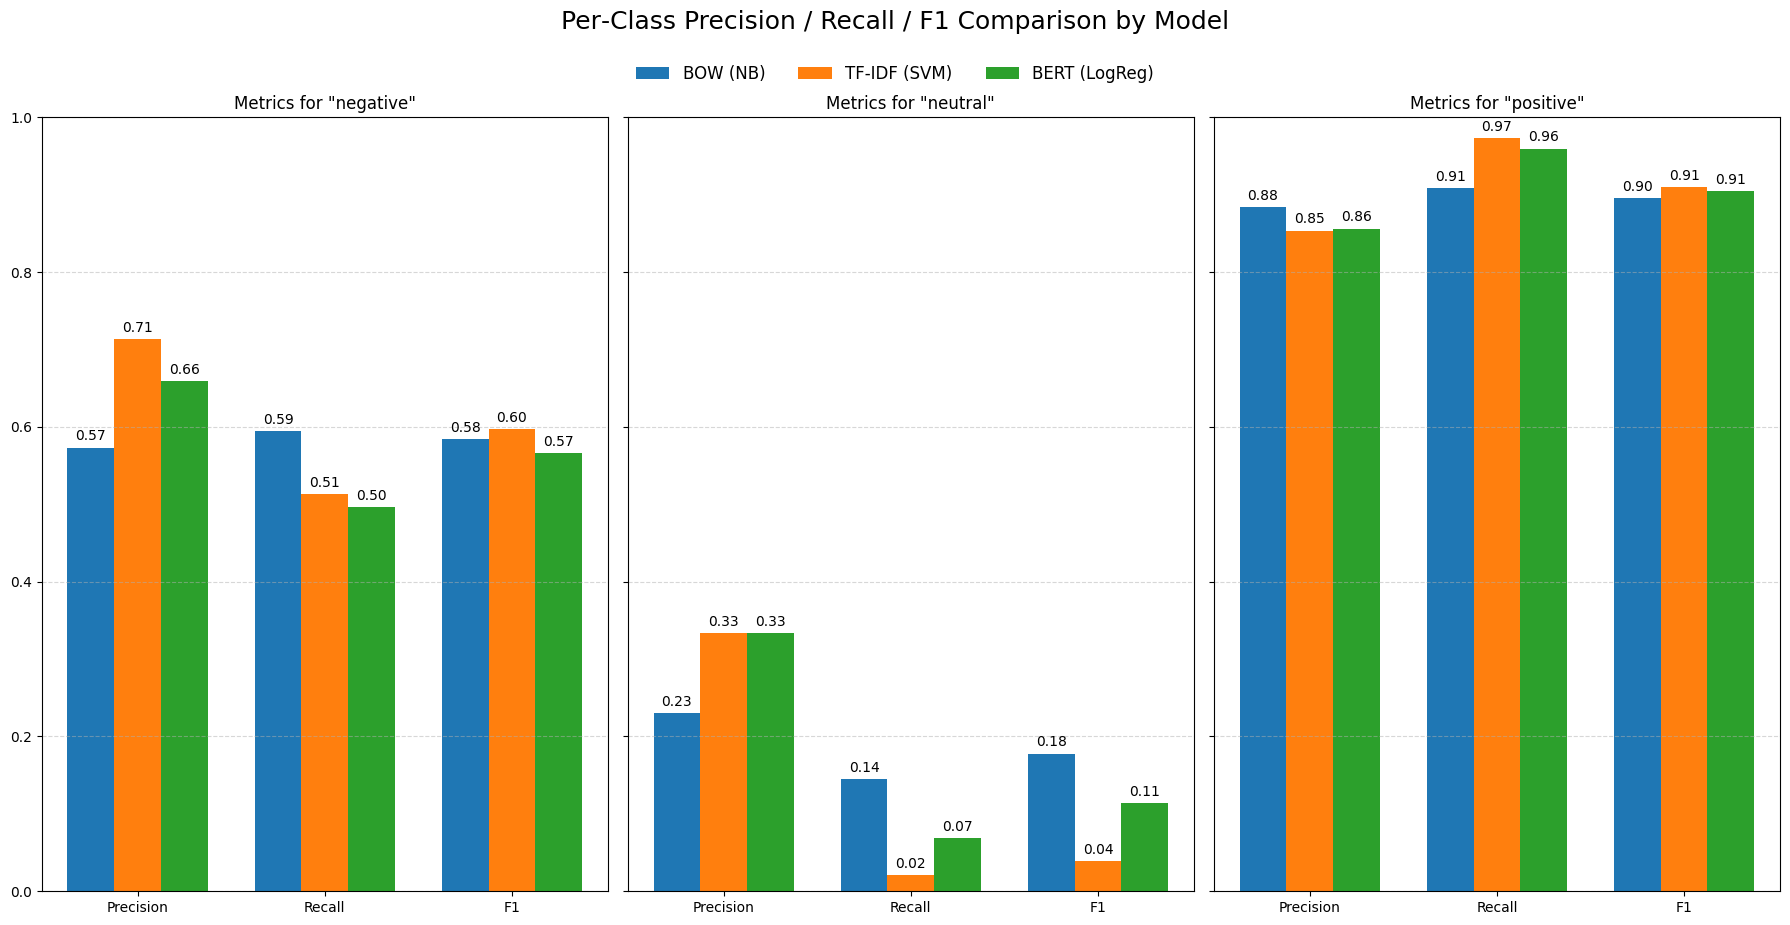

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Initializing a dictionary to hold the model predictions
model_preds = {
    'BOW (NB)':      y_pred_bow,
    'TF-IDF (SVM)':  y_pred_svm,
    'BERT (LogReg)': y_pred_logreg
}

# Initializing another dictionary to hold the metrics for each model
metrics = {}

for name, preds in model_preds.items():
    p, r, f1, _ = precision_recall_fscore_support(
        y_test, preds,
        average=None,
        labels=range(len(class_names))
    )
    metrics[name] = {'precision': p, 'recall': r, 'f1': f1}

metric_keys  = ['precision','recall','f1']
x            = np.arange(len(metric_keys))
width        = 0.25
model_labels = list(metrics.keys())

# Create subplots with constrained_layout off so we can manually carve out space
fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharey=True)

for idx, cls in enumerate(class_names):
    ax = axes[idx]
    for i, model in enumerate(model_labels):
        vals = [metrics[model][k][idx] for k in metric_keys]
        ax.bar(x + (i-1)*width, vals, width, label=model)
    # annotate    
    for bar in ax.patches:
        ax.annotate(
            f"{bar.get_height():.2f}",
            xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
            xytext=(0,3), textcoords="offset points",
            ha='center', va='bottom', fontsize=10
        )
    ax.set_xticks(x)
    ax.set_xticklabels([k.capitalize() for k in metric_keys])
    ax.set_ylim(0,1)
    ax.set_title(f'Metrics for "{cls}"')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

# Carve out the top 15% of the figure for title + legend
plt.tight_layout(rect=[0, 0, 1, 0.85])

# Super‑title (main heading)
fig.suptitle(
    "Per‑Class Precision / Recall / F1 Comparison by Model",
    fontsize=18,
    y=0.92
)

# Global legend just below the suptitle
fig.legend(
    model_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 0.88),
    ncol=len(model_labels),
    frameon=False,
    fontsize=12
)

plt.show()

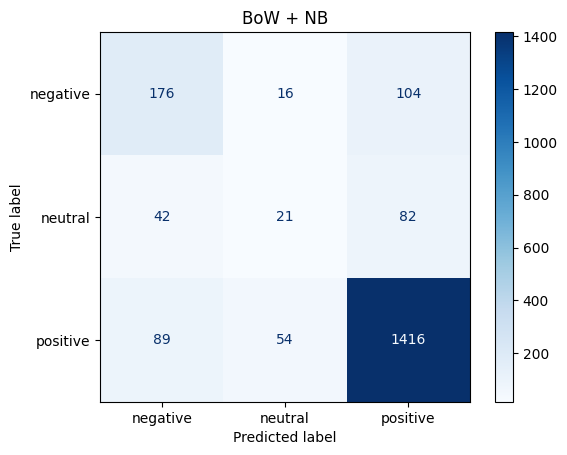

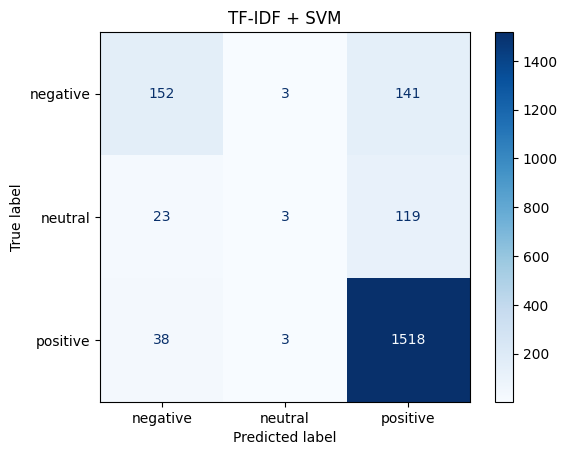

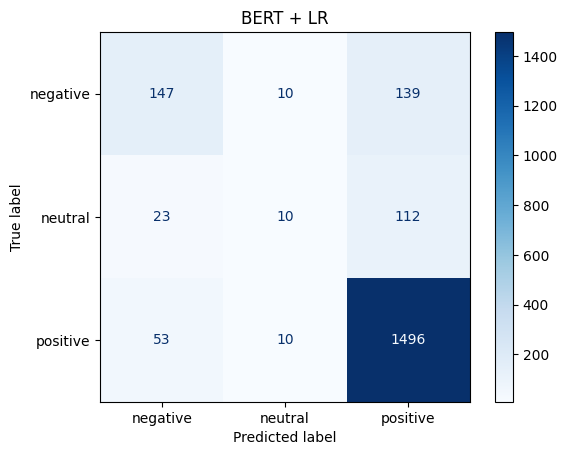

In [83]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Quick loop to plot all three confusion matrices
model_preds = [
    ("BoW + NB", y_pred_bow),
    ("TF-IDF + SVM", y_pred_svm),
    ("BERT + LR", y_pred_logreg),
]

for name, preds in model_preds:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        preds,
        display_labels=le.classes_,
        cmap='Blues',
        values_format='d'
    )
    disp.ax_.set_title(name)
    plt.show()


---

### Running test cases with the best model (model with the highest accuracy)

In [93]:
for i in range(1,3):
    review  = input("Enter a review: ")
    cleaned = basic_text_cleaning(review)

    # wrap in a Series so clean_sentences can call .fillna()
    tokens = clean_sentences(pd.Series([cleaned]))[0]

    input_vec = vectorizer.transform([tokens]).toarray()
    pred_idx  = model.predict(input_vec)
    sentiment = le.inverse_transform(pred_idx)[0]
    print(f"\nReview: “{review}”\nPredicted sentiment: {sentiment}")


Review: “I enjoyed the seafood but my wife did not like it that much”
Predicted sentiment: positive

Review: “My girlfriend hated the noodles I bought for her because it was too spicy for her”
Predicted sentiment: negative


<h2>Conclusion</h2>
<p><strong>Logistic Regression with BERT</strong> achieved an overall accuracy of <strong>0.83</strong>. It excelled at identifying positive reviews (recall 0.96, F₁ 0.91) and delivered solid negative precision (0.66, F₁ 0.57), but struggled to detect neutral sentiment (recall 0.07, F₁ 0.11).</p>
<p><strong>SVM with TF‑IDF</strong> posted the highest accuracy of <strong>0.84</strong>. It offered the best negative‑class performance (precision 0.71, recall 0.51, F₁ 0.60) and matched BERT on positive‑class F₁ (0.91, recall 0.97), though neutral recall remained very low (0.02, F₁ 0.04).</p>
<p><strong>Bag‑of‑Words with Naïve Bayes</strong> reached <strong>0.81</strong> accuracy. It delivered balanced negative recall (0.59, F₁ 0.58) and robust positive detection (precision 0.88, F₁ 0.90), but underperformed on neutral reviews (recall 0.14, F₁ 0.18).</p>

<h2>Recommendations</h2>
<ul>
  <li><strong>Deploy SVM + TF‑IDF</strong> as the primary classifier. Its 84 % accuracy, highest negative‑class F₁ (0.60), and near‑perfect positive recall (0.97) make it the most balanced solution.</li>
  <li><strong>Improve neutral‑class detection</strong> by collecting or synthesizing additional neutral examples, applying class weighting or targeted oversampling, and engineering hedging‑word features (e.g. “okay,” “average,” “moderate”).</li>
  <li><strong>Fine‑tune and ensemble</strong> – conduct an SVM grid search on C and kernel choices, experiment with deeper models on BERT embeddings, or introduce a two‑stage “neutral vs. polarized” pipeline to boost recall on mixed‑sentiment reviews.</li>
</ul>
